# Data Mining I - Should we loan?

## Group

* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* João Veloso, up202005801

## Problem statement



* A bank is enhancing customer service quality by identifying good and bad clients using data mining techniques. The project aims to help bank managers understand clients and identify suitable credit card candidates. Two learning problems are addressed: descriptive and predictive, focusing on loan success.

## Task 1: Data Understanding and Preparation

* Firstly, we import the necessary libraries, packages and methods.

In [3474]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.preprocessing import LabelEncoder

* We read the data from the CSV files and check the data using the head(), describe(), and other Pandas commands.

In [3475]:
account = pd.read_csv('bank/account.csv', delimiter=";")
card_dev = pd.read_csv('bank/card_dev.csv', delimiter=";")
client = pd.read_csv('bank/client.csv', delimiter=";")
disp = pd.read_csv('bank/disp.csv', delimiter=";")
district = pd.read_csv('bank/district.csv', delimiter=";")
loan_dev = pd.read_csv('bank/loan_dev.csv', delimiter=";")
trans_dev = pd.read_csv('bank/trans_dev.csv', delimiter=";")

/tmp/ipykernel_9090/3453540627.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = pd.read_csv('bank/trans_dev.csv', delimiter=";")


### Account

In [3476]:
print(str(account.shape[0]) + " rows and " + str(account.shape[1]) + " cols")
account.head()

4500 rows and 4 cols


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102


In [3477]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 140.8+ KB


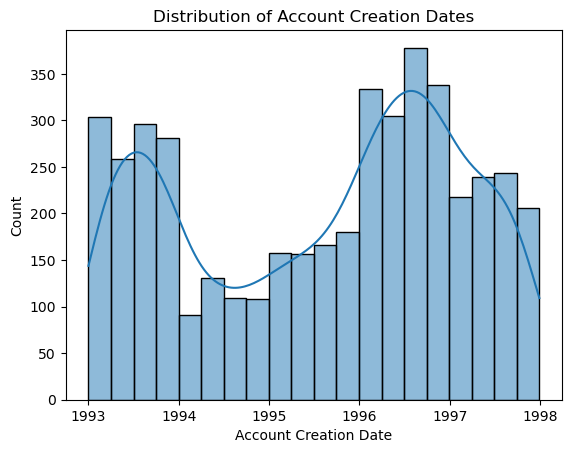

In [3478]:
account['date'] = pd.to_datetime(account['date'], format='%y%m%d')
sns.histplot(account['date'], bins=20, kde=True)
plt.xlabel('Account Creation Date')
plt.title('Distribution of Account Creation Dates')
plt.show()

Here we can see that there were significantly more accounts created in 1993 and 1996  
It might be more interesting to have the age of the account so we'll add that.

In [3479]:
def calculate_account_age(row):
    date = pd.to_datetime(row['date'], format='%y%m%d')
    age = 1997 - date.year
    return age

account['account_age'] = account.apply(calculate_account_age, axis=1)

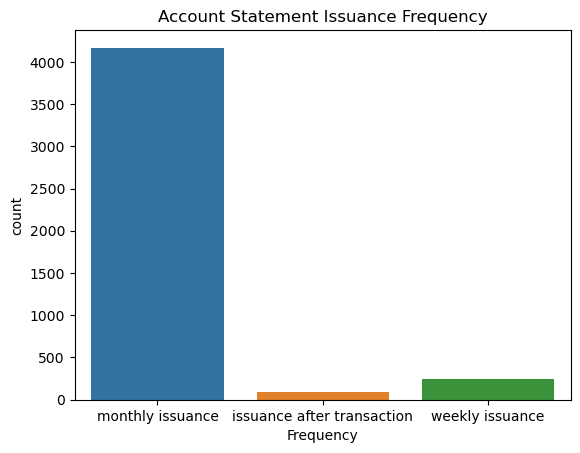

In [3480]:
sns.countplot(x='frequency', data=account)
plt.title("Account Statement Issuance Frequency")
plt.xlabel("Frequency")
plt.show()

We can also see that the vast majority of accounts have a monthly frequency of statement issuance

#### Missing Values

In [3481]:
print(account.isna().sum())
print()
print("There are " + str((account.isna().sum().sum())) + " NA values")

account_id     0
district_id    0
frequency      0
date           0
account_age    0
dtype: int64

There are 0 NA values


#### Duplicate values

In [3482]:
print("Dataset length: " + str(len(account)))
print("Number of duplicates: " + str(account.duplicated().sum()))

Dataset length: 4500
Number of duplicates: 0


### Credit Card

In [3483]:
print(str(card_dev.shape[0]) + " rows and " + str(card_dev.shape[1]) + " cols")
card_dev.head()

177 rows and 4 cols


,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215


In [3484]:
card_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  177 non-null    int64 
 1   disp_id  177 non-null    int64 
 2   type     177 non-null    object
 3   issued   177 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 5.7+ KB


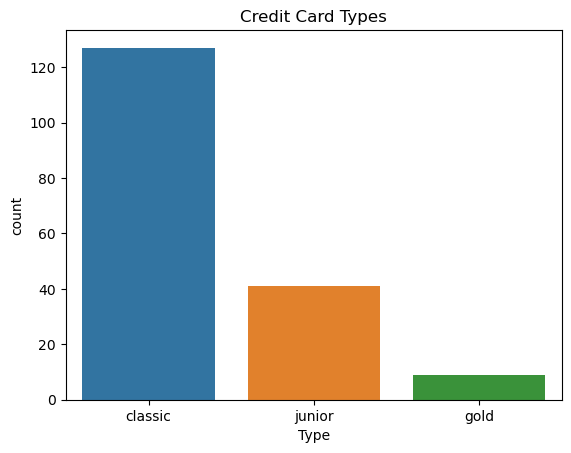

In [3485]:
sns.countplot(x='type', data=card_dev)
plt.title("Credit Card Types")
plt.xlabel("Type")
plt.show()

There are less than 200(!) credit cards even though that there are more than 4000 accounts.
Of these, more than half are in the "classic category".

#### Missing Values

In [3486]:
print(card_dev.isna().sum())
print()
print("There are " + str((card_dev.isna().sum().sum())) + " NA values")

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

There are 0 NA values


#### Duplicate values

In [3487]:
print("Dataset length: " + str(len(card_dev)))
print("Number of duplicates: " + str(card_dev.duplicated().sum()))

Dataset length: 177
Number of duplicates: 0


### Transaction

In [3488]:
print(str(trans_dev.shape[0]) + " rows and " + str(trans_dev.shape[1]) + " cols")
trans_dev.head()

396685 rows and 10 cols


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN


In [3489]:
trans_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396685 entries, 0 to 396684
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   trans_id    396685 non-null  int64  
 1   account_id  396685 non-null  int64  
 2   date        396685 non-null  int64  
 3   type        396685 non-null  object 
 4   operation   325924 non-null  object 
 5   amount      396685 non-null  float64
 6   balance     396685 non-null  float64
 7   k_symbol    211441 non-null  object 
 8   bank        97242 non-null   object 
 9   account     102229 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 30.3+ MB


In [3490]:
trans_dev.describe()

,trans_id,account_id,date,amount,balance,account
count,3.966850e+05,396685.000000,396685.000000,396685.000000,396685.000000,1.022290e+05
mean,1.239338e+06,2508.434796,951310.066801,5677.552980,35804.792507,4.664229e+07
std,1.213288e+06,2020.928889,9510.974536,9190.364137,19692.148243,3.002136e+07
min,1.000000e+00,1.000000,930101.000000,0.000000,-13588.700000,0.000000e+00
25%,3.918330e+05,1092.000000,941110.000000,127.500000,22424.300000,1.990018e+07
50%,7.882580e+05,2220.000000,950930.000000,1952.000000,30959.600000,4.673618e+07
75%,1.273700e+06,3357.000000,960606.000000,6500.000000,44661.000000,7.232217e+07
max,3.682934e+06,11382.000000,961231.000000,86400.000000,193909.900000,9.998564e+07


#### Types

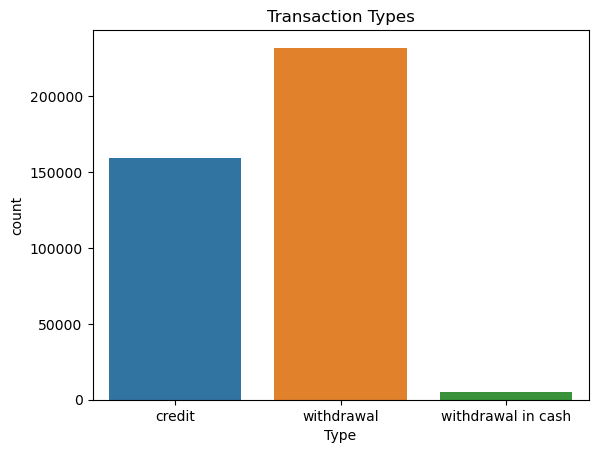

In [3491]:
sns.countplot(x="type", data=trans_dev)
plt.title("Transaction Types")
plt.xlabel("Type")
plt.show()


It seems odd that there are both "withdrawal" and "withdrawal in cash" types so we´ll investigate further...

In [3492]:
type_counts = trans_dev['type'].value_counts()

withdrawal_count = type_counts.get('withdrawal', 0)
withdrawal_in_cash_count = type_counts.get('withdrawal in cash', 0)

print("Withdrawal Count:", withdrawal_count)
print("Withdrawal in Cash Count:", withdrawal_in_cash_count)

Withdrawal Count: 232093
Withdrawal in Cash Count: 5124


In [3493]:
withdrawals = trans_dev[trans_dev['operation'] == 'withdrawal in cash']

type_counts_filtered = withdrawals['type'].value_counts()

withdrawal_count = type_counts_filtered.get('withdrawal', 0)
withdrawal_in_cash_count = type_counts_filtered.get('withdrawal in cash', 0)

print("Withdrawal Count:", withdrawal_count)
print("Withdrawal in Cash Count:", withdrawal_in_cash_count)

Withdrawal Count: 160146
Withdrawal in Cash Count: 5124


It seems some of the records were registered in column type with "withdrawal in cash" by error so we´ĺl fix it 

In [3494]:
trans_dev['type'] = trans_dev['type'].replace('withdrawal in cash', 'withdrawal')

#### Operation Types

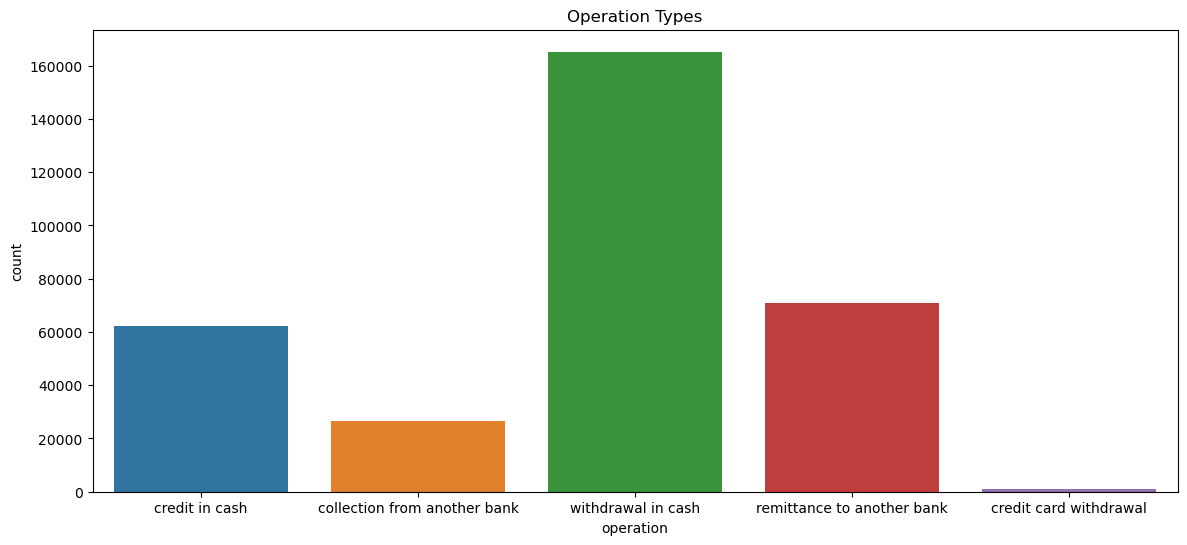

In [3495]:
plt.figure(figsize=(14, 6))
sns.countplot(x="operation", data=trans_dev)
plt.title("Operation Types")
plt.xlabel("operation")
plt.show()

Similarly to above, withdrawal seems to be fragmented into 2 separate types, probably due to human error

In [3496]:
type_counts = trans_dev['operation'].value_counts()

withdrawal_in_cash_count = type_counts.get('withdrawal in cash', 0)
credit_card_withdrawal_count = type_counts.get('credit card withdrawal', 0)

print("Withdrawal in Cash Count:", withdrawal_in_cash_count)
print("Credit card withdrawal Count:", credit_card_withdrawal_count)

Withdrawal in Cash Count: 165270
Credit card withdrawal Count: 1210


So we´ll join the 2

In [3497]:
trans_dev['operation'] = trans_dev['operation'].replace('credit card withdrawal', 'withdrawal in cash')

In [3498]:
cross_tab = pd.crosstab(trans_dev['operation'], trans_dev['type'])

print(cross_tab)


type                          credit  withdrawal
operation                                       
collection from another bank   26505           0
credit in cash                 62202           0
remittance to another bank         0       70737
withdrawal in cash                 0      166480


We can now see that values of column type are mutually exclusive when it comes to the values of column operation.

In [3499]:
null_entries = trans_dev['operation'].isnull().sum()
not_null_entries = trans_dev['operation'].notnull().sum()


print("Number of null entries in 'operation' column:", null_entries)
print("Number of not null entries in 'operation' column:", not_null_entries)

Number of null entries in 'operation' column: 70761
Number of not null entries in 'operation' column: 325924


In [3500]:
cross_tab = pd.crosstab(trans_dev['k_symbol'], trans_dev['operation'].isnull())

print(cross_tab)

operation                              False  True 
k_symbol                                           
                                       19065      0
household                              42839      0
insurrance payment                      6592      0
interest credited                          0  70761
old-age pension                        13502      0
payment for statement                  58377      0
sanction interest if negative balance    305      0


We can see that the number of null operation matches are all with k symbol "interest credited"  
We will fill these with "credit in cash"

In [3501]:
trans_dev['operation'] = trans_dev['operation'].fillna("credit in cash")

#### K Symbol

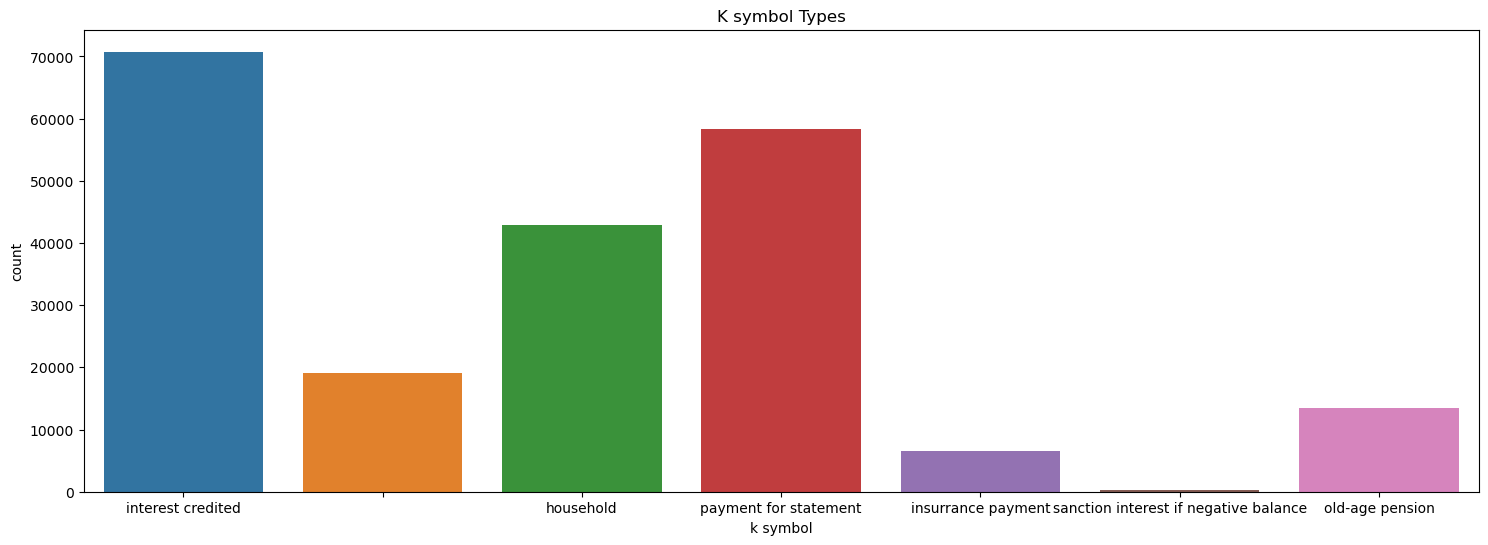

In [3502]:
plt.figure(figsize=(18, 6))
sns.countplot(x="k_symbol", data=trans_dev)
plt.title("K symbol Types")
plt.xlabel("k symbol")
plt.show()

In [3503]:
cross_tab = pd.crosstab(trans_dev['k_symbol'],trans_dev['type'])
print(cross_tab)

type                                   credit  withdrawal
k_symbol                                                 
                                            0       19065
household                                   0       42839
insurrance payment                          0        6592
interest credited                       70761           0
old-age pension                         13502           0
payment for statement                       0       58377
sanction interest if negative balance       0         305


Once again, the non null values of column K symbol are mutually exclusive to the column type.
We can also see that when k symbol is " " (not to be confused with "" which is considered null) always refers to withdrawal so it safe to assume that these refer to general day-to-day expenses and so we we´properly tag it as such.

In [3504]:
trans_dev['k_symbol'] = trans_dev['k_symbol'].replace(r'^\s*$', "regular expense", regex=True) #first argument is a regular expresion that replaces the values " "

In [3505]:
cross_tab = pd.crosstab(trans_dev['operation'],trans_dev['k_symbol'].isnull())
print(cross_tab)

k_symbol                      False   True 
operation                                  
collection from another bank  13502   13003
credit in cash                70761   62202
remittance to another bank    67268    3469
withdrawal in cash            59910  106570


## TODO continuar esta parte
When it comes to the null entries there doesnt seem to be any obvious patterns so inferring that they should something or other is more challenging...

In [3506]:
#fazer algo sobre null entries na coluna k symbol aqui

#### Target bank

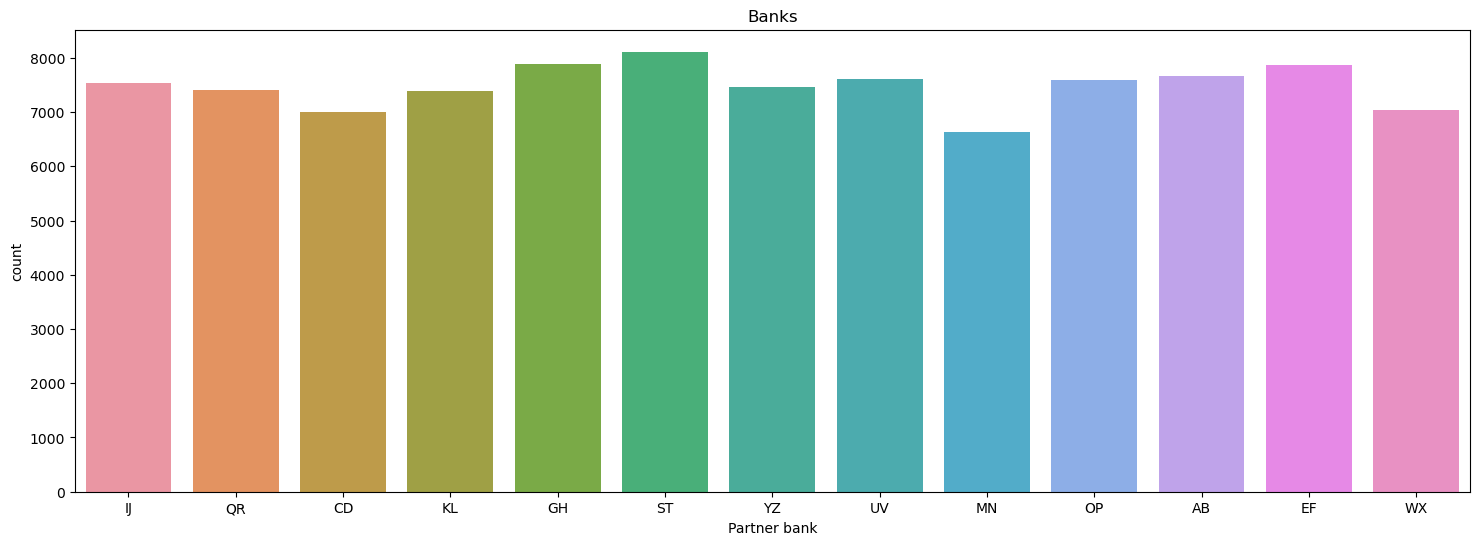

In [3507]:
plt.figure(figsize=(18, 6))
sns.countplot(x="bank", data=trans_dev)
plt.title("Banks")
plt.xlabel("Partner bank")
plt.show()

Overall, transactions are made more or less with the same frequency to the various partner banks

In [3508]:
null_entries = trans_dev['bank'].isnull().sum()
not_null_entries = trans_dev['bank'].notnull().sum()

# Display the number of null entries
print("Number of null entries in 'bank' column:", null_entries)
print("Number of not null entries in 'bank' column:", not_null_entries)

Number of null entries in 'bank' column: 299443
Number of not null entries in 'bank' column: 97242


There are much more null entries that not null ones (aproxmately 3 times more).

In [3509]:
cross_tab = pd.crosstab(trans_dev['operation'], trans_dev['bank'].isnull())
print(cross_tab)

bank                          False   True 
operation                                  
collection from another bank  26505       0
credit in cash                    0  132963
remittance to another bank    70737       0
withdrawal in cash                0  166480


We can see that all the rows with null in column bank dont belong to one operation that states "another bank" so its easy to infer that these are transactions are made within the same bank.
We'll change the null value to a proper name.

In [3510]:
trans_dev['bank'] = trans_dev['bank'].fillna("DJ")

#### Target Account

We noticed that the column "account" which represents the target account has a few rows where the value is 0 and a lot more where the value is null so lets explore that.

In [3511]:
cross_tab = pd.crosstab(trans_dev['type'], trans_dev['account'] == 0)
print(cross_tab)

account      False  True 
type                     
credit      159468      0
withdrawal  232230   4987


In [3512]:
cross_tab = pd.crosstab(trans_dev['bank'], trans_dev['account'].isnull())
print(cross_tab)
cross_tab = pd.crosstab(trans_dev['k_symbol'],  trans_dev['account'].isnull())
print(cross_tab)

account  False   True 
bank                  
AB        7666       0
CD        7009       0
DJ        4987  294456
EF        7878       0
GH        7886       0
IJ        7536       0
KL        7397       0
MN        6626       0
OP        7595       0
QR        7413       0
ST        8114       0
UV        7618       0
WX        7033       0
YZ        7471       0
account                                False  True 
k_symbol                                           
household                              42839      0
insurrance payment                      6592      0
interest credited                          0  70761
old-age pension                        13502      0
payment for statement                      0  58377
regular expense                        19065      0
sanction interest if negative balance      0    305


As we can see all that have the value set to 0, are of the type withdrawal.
We decided to add the id of the account itself to the target

As for the null ones they are also all within the same bank, and are by lookin at the k symbol values for it, seems to be payments to/from the bank itself.
For these, we decided to use the value 0, since it has just been freed, to represent the bank itself

In [3513]:
trans_dev.loc[trans_dev['account'] == 0, 'account'] = trans_dev['account_id']

In [3514]:
trans_dev["account"].fillna(0,inplace=True)

#### Dates

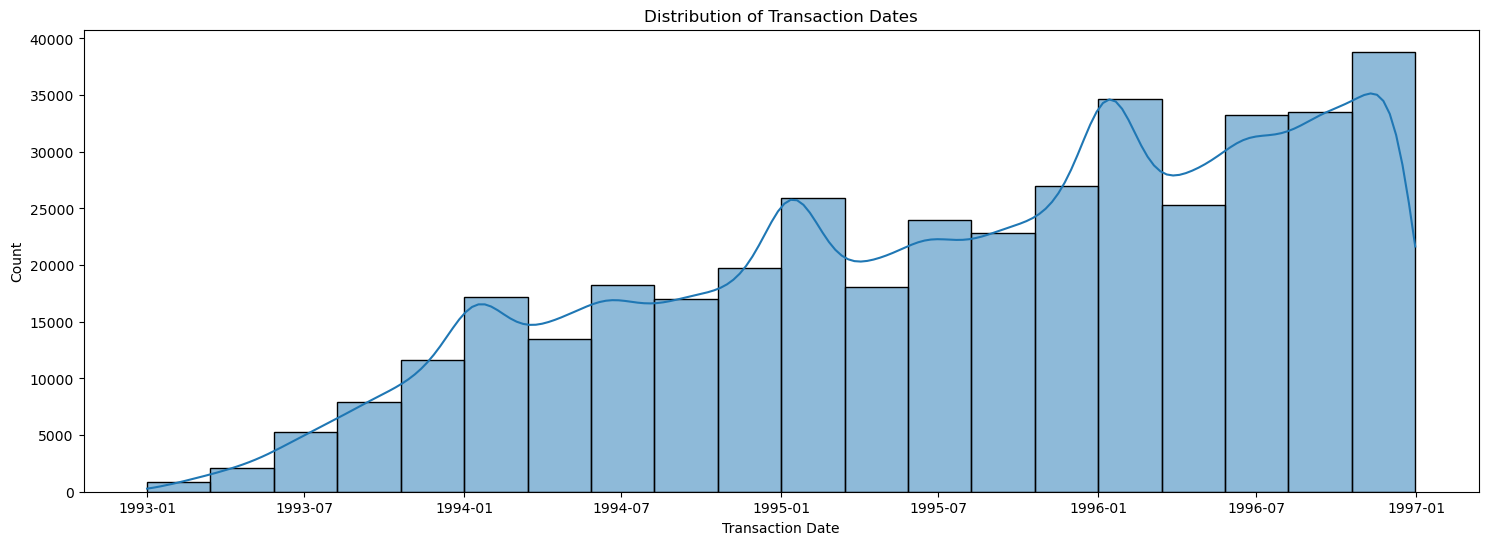

In [3515]:
trans_dev['date']=pd.to_datetime(trans_dev['date'], format='%y%m%d')
plt.figure(figsize=(18, 6))
sns.histplot(trans_dev['date'], bins=20, kde=True)
plt.xlabel('Transaction Date')
plt.title('Distribution of Transaction Dates')
plt.show()

There seems to be a spike of transaction are the end of the year, probably related to the christmas season

#### Missing Values

In [3516]:
print(trans_dev.isna().sum())
print()
print("There are " + str(trans_dev.isna().sum().sum()) + " NA values")

trans_id           0
account_id         0
date               0
type               0
operation          0
amount             0
balance            0
k_symbol      185244
bank               0
account            0
dtype: int64

There are 185244 NA values


#### Duplicate values

In [3517]:
print("Dataset length: " + str(len(trans_dev)))
print("Number of duplicates: " + str(trans_dev.duplicated().sum()))

Dataset length: 396685
Number of duplicates: 0


#### Correlation matrix

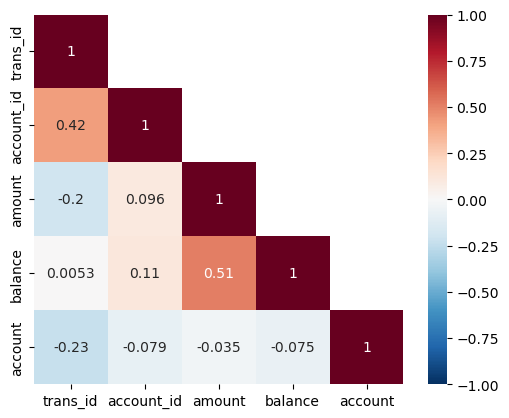

In [3518]:
numeric_cols = trans_dev.select_dtypes(include=np.number).columns.tolist()

corr_matrix = trans_dev[numeric_cols].corr()

mask = np.tri(corr_matrix.shape[0], dtype=bool)

sns.heatmap(corr_matrix, mask=~mask, cmap='RdBu_r', square=True, vmin=-1, vmax=1, annot=True)
plt.show()

### Client

In [3519]:
print(str(client.shape[0]) + " rows and " + str(client.shape[1]) + " cols")
client.head()

5369 rows and 3 cols


,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [3520]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


The dataset has a "birth_number" column that is codified to include both date of birth and sex in the same column, so we´ll decodify it...

#### Add 'sex' and 'age' columns to the Client dataframe

In [3521]:
client = pd.read_csv('bank/client.csv', delimiter=";")

client['sex'] = client['birth_number'].apply(lambda x: 'Male' if int(str(x)[2:4]) <= 12 else 'Female')

def calculate_age(row):
    #current_year = datetime.now().year
    if row['sex'] == 'Male':
        birth_date = datetime(int('19' + str(row['birth_number'])[0:2]), int(str(row['birth_number'])[2:4]), int(str(row['birth_number'])[4:6]))
    else:
        birth_date = datetime(int('19' + str(row['birth_number'])[0:2]), int(str(row['birth_number'])[2:4]) - 50, int(str(row['birth_number'])[4:6]))
    age = 1997 - birth_date.year #- ((datetime.now().month, datetime.now().day) < (birth_date.month, birth_date.day))
    return age

client['age'] = client.apply(calculate_age, axis=1)
client.drop('birth_number', axis=1, inplace=True)

print(client[['age', 'sex']])

      age     sex
0      27  Female
1      52    Male
2      57  Female
3      41    Male
4      37  Female
...   ...     ...
5364   52  Female
5365   54    Male
5366   29    Male
5367   35  Female
5368   44  Female

[5369 rows x 2 columns]


In [3522]:
m = client['sex'].value_counts()['Male']
f = client['sex'].value_counts()['Female']
print("Number of men:", m)
print("Number of women:", f)

Number of men: 2724
Number of women: 2645


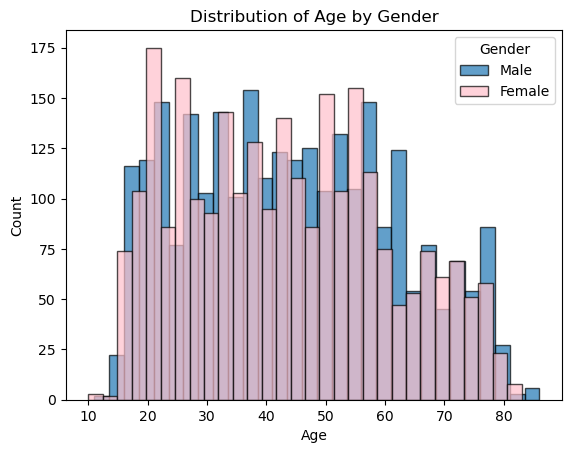

In [3523]:
men_birth_years = client[client['sex'] == 'Male']['age']
women_birth_years = client[client['sex'] == 'Female']['age']

plt.hist(men_birth_years, bins=30, alpha=0.7, label='Male', edgecolor='black')
plt.hist(women_birth_years, bins=30, alpha=0.7, label='Female', color='pink', edgecolor='black')

plt.title('Distribution of Age by Gender')
plt.xlabel('Age')
plt.ylabel('Count')

plt.legend(title="Gender")
plt.show()

#### Missing Values

In [3524]:
print(client.isna().sum())
print()
print("There are " + str((client.isna().sum().sum())) + " NA values")

client_id      0
district_id    0
sex            0
age            0
dtype: int64

There are 0 NA values


#### Duplicate values

In [3525]:
print("Dataset length: " + str(len(client)))
print("Number of duplicates: " + str(client.duplicated().sum()))

Dataset length: 5369
Number of duplicates: 0


### Disposition

In [3526]:
print(str(disp.shape[0]) + " rows and " + str(disp.shape[1]) + " cols")
disp.head()

5369 rows and 4 cols


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [3527]:
disp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


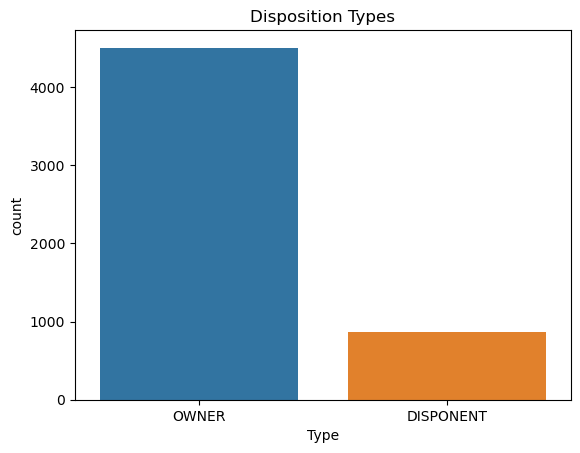

In [3528]:
sns.countplot(x='type', data=disp)
plt.title("Disposition Types")
plt.xlabel("Type")
plt.show()

#### Missing Values

In [3529]:
print(disp.isna().sum())
print()
print("There are " + str((disp.isna().sum().sum())) + " NA values")

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

There are 0 NA values


#### Duplicate values

In [3530]:
print("Dataset length: " + str(len(disp)))
print("Number of duplicates: " + str(disp.duplicated().sum()))

Dataset length: 5369
Number of duplicates: 0


### Demographic data

In [3531]:
print(str(district.shape[0]) + " rows and " + str(district.shape[1]) + " cols")
district.head()

77 rows and 16 cols


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [3532]:
district.info()
#print(district.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   code                                              77 non-null     int64  
 1   name                                              77 non-null     object 
 2   region                                            77 non-null     object 
 3   no. of inhabitants                                77 non-null     int64  
 4   no. of municipalities with inhabitants < 499      77 non-null     int64  
 5   no. of municipalities with inhabitants 500-1999   77 non-null     int64  
 6   no. of municipalities with inhabitants 2000-9999  77 non-null     int64  
 7   no. of municipalities with inhabitants >10000     77 non-null     int64  
 8   no. of cities                                     77 non-null     int64  
 9   ratio of urban inhabita

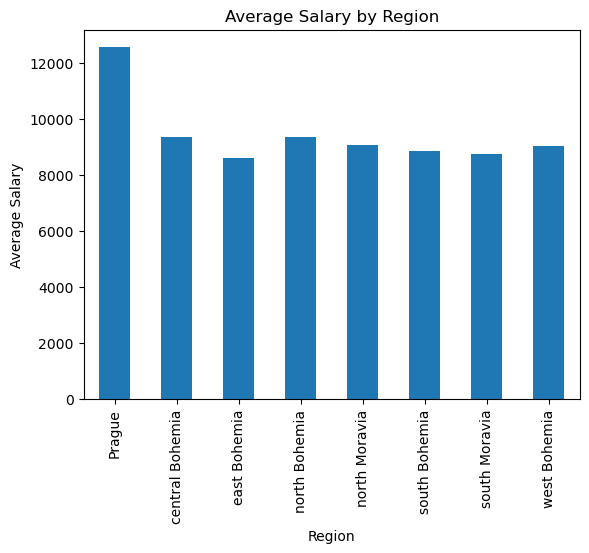

In [3533]:
average_salary = district.groupby('region')['average salary'].mean()
average_salary.plot(kind='bar')
plt.title('Average Salary by Region')
plt.xlabel('Region')
plt.ylabel('Average Salary')
plt.show()

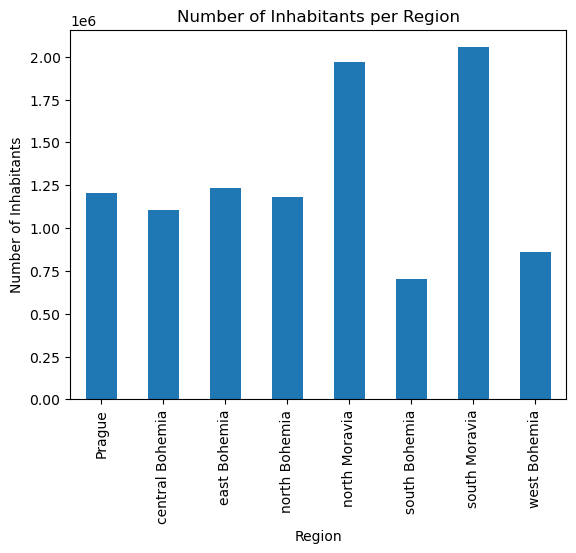

In [3534]:
inhabitants_per_region = district.groupby('region')['no. of inhabitants'].sum()
inhabitants_per_region.plot(kind='bar')
plt.title('Number of Inhabitants per Region')
plt.xlabel('Region')
plt.ylabel('Number of Inhabitants')
plt.show()


In [3535]:
district.describe()

,code,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '96
count,77.000000,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,39.000000,1.338849e+05,48.623377,24.324675,6.272727,1.727273,6.259740,63.035065,9031.675325,3.787013,116.129870,5030.831169
std,22.371857,1.369135e+05,32.741829,12.780991,4.015222,1.008338,2.435497,16.221727,790.202347,1.908480,16.608773,11270.796786
min,1.000000,4.282100e+04,0.000000,0.000000,0.000000,0.000000,1.000000,33.900000,8110.000000,0.430000,81.000000,888.000000
25%,20.000000,8.585200e+04,22.000000,16.000000,4.000000,1.000000,5.000000,51.900000,8512.000000,2.310000,105.000000,2122.000000
50%,39.000000,1.088710e+05,49.000000,25.000000,6.000000,2.000000,6.000000,59.800000,8814.000000,3.600000,113.000000,3040.000000
75%,58.000000,1.390120e+05,71.000000,32.000000,8.000000,2.000000,8.000000,73.500000,9317.000000,4.790000,126.000000,4595.000000
max,77.000000,1.204953e+06,151.000000,70.000000,20.000000,5.000000,11.000000,100.000000,12541.000000,9.400000,167.000000,99107.000000


#### Missing Values

In [3536]:
district.replace('?', np.nan, inplace=True)
print(district.isna().sum())
print()
print("There are " + str((district.isna().sum().sum())) + " NA values")

code                                                0
name                                                0
region                                              0
no. of inhabitants                                  0
no. of municipalities with inhabitants < 499        0
no. of municipalities with inhabitants 500-1999     0
no. of municipalities with inhabitants 2000-9999    0
no. of municipalities with inhabitants >10000       0
no. of cities                                       0
ratio of urban inhabitants                          0
average salary                                      0
unemploymant rate '95                               1
unemploymant rate '96                               0
no. of enterpreneurs per 1000 inhabitants           0
no. of commited crimes '95                          1
no. of commited crimes '96                          0
dtype: int64

There are 2 NA values


##### Impute missing values with the mean of the column

In [3537]:
district['no. of commited crimes \'95'] = pd.to_numeric(district['no. of commited crimes \'95'], errors='coerce')
mean_value = district['no. of commited crimes \'95'].mean()
district['no. of commited crimes \'95'].fillna(mean_value, inplace=True)
district['no. of commited crimes \'95'] = district['no. of commited crimes \'95'].astype(int)

district['unemploymant rate \'95'] = pd.to_numeric(district['unemploymant rate \'95'], errors='coerce')
mean_value = district['unemploymant rate \'95'].mean()
district['unemploymant rate \'95'].fillna(mean_value, inplace=True)
district['unemploymant rate \'95'] = district['unemploymant rate \'95'].astype(float)

Demographic data is a prime example of feature extraction, and we can create several new features

In [3538]:
district['unemployment_growth'] = district['unemploymant rate \'96'] - district['unemploymant rate \'95']

district['commited_crimes_growth'] = round(((district['no. of commited crimes \'96'] - district['no. of commited crimes \'95'])/district['no. of commited crimes \'95'])*100,2)

district['crime rate'] = (district['no. of commited crimes \'96'] / district['no. of inhabitants'] * 100000).astype(int)

district['entrepreneurs_percentage'] = (district['no. of enterpreneurs per 1000 inhabitants'] / 10)

district['urban_population_density'] = (district['no. of inhabitants'] * (district['ratio of urban inhabitants'] / 100)).astype(int)

district.head()

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,...,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,unemployment_growth,commited_crimes_growth,crime rate,entrepreneurs_percentage,urban_population_density
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,...,0.29,0.43,167,85677,99107,0.14,15.68,8224,16.7,1204953
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,...,1.67,1.85,132,2159,2674,0.18,23.85,3008,13.2,41508
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,...,1.95,2.21,111,2824,2813,0.26,-0.39,3739,11.1,31371
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,...,4.64,5.05,109,5244,5892,0.41,12.36,3930,10.9,101027
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,...,3.85,4.43,118,2616,3040,0.58,16.21,3179,11.8,49146


#### Duplicate values

In [3539]:
print("Dataset length: " + str(len(district)))
print("Number of duplicates: " + str(district.duplicated().sum()))

Dataset length: 77
Number of duplicates: 0


#### Correlation matrix

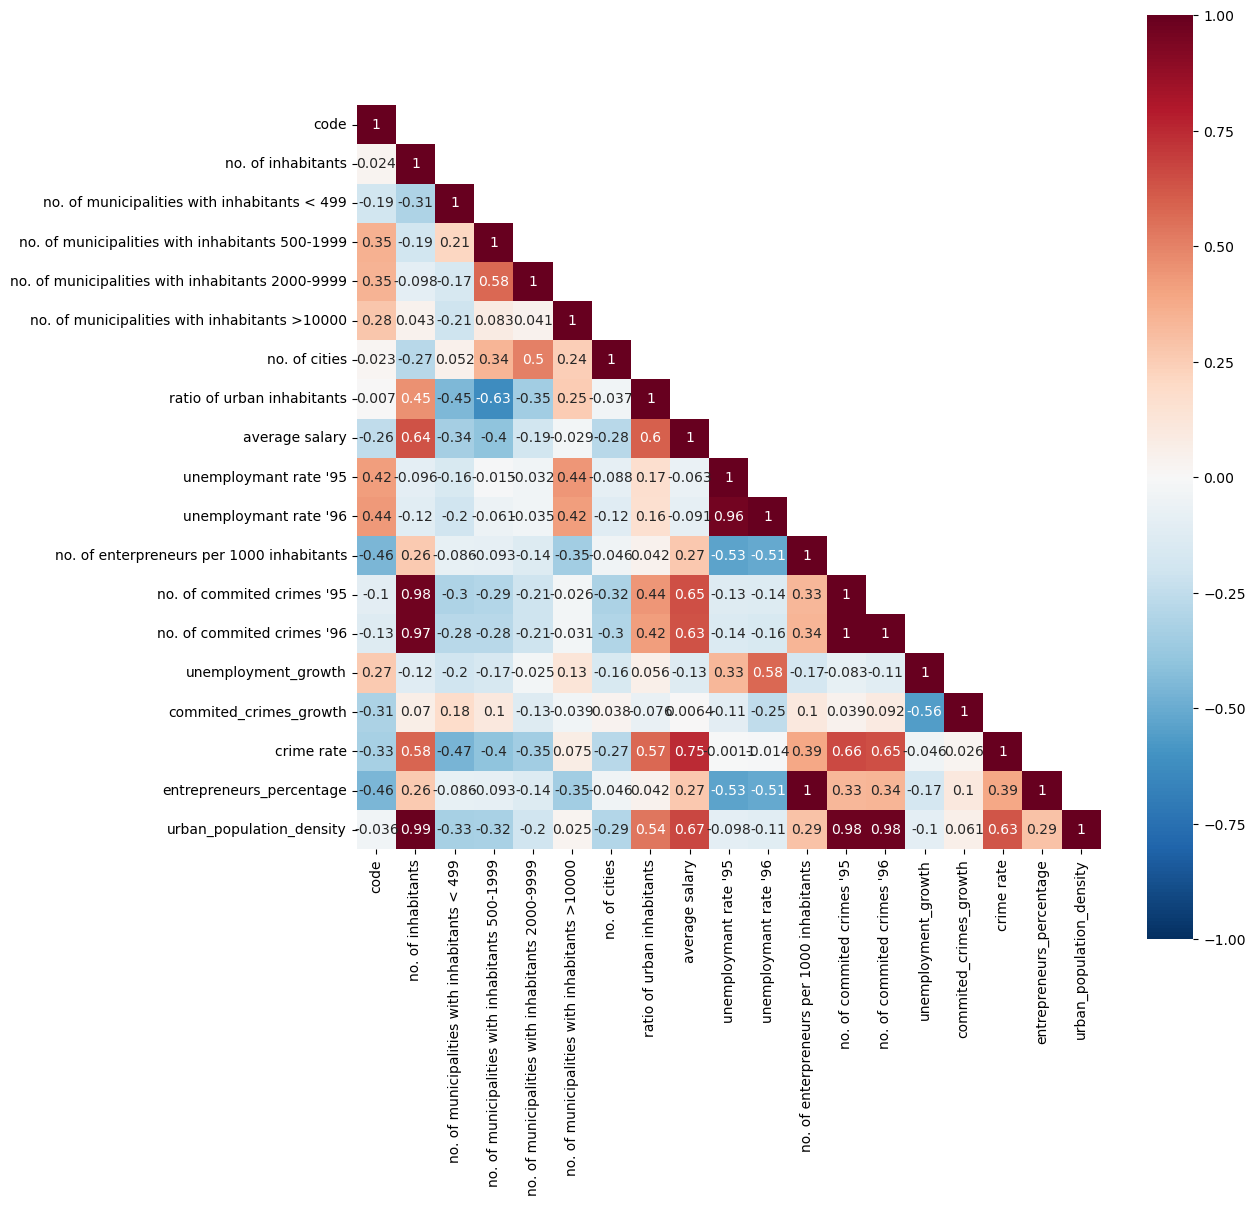

In [3541]:
numeric_cols = district.select_dtypes(include=np.number).columns.tolist()

corr_matrix = district[numeric_cols].corr()

mask = np.tri(corr_matrix.shape[0], dtype=bool)

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, mask=~mask, cmap='RdBu_r', square=True, vmin=-1, vmax=1, annot=True)
plt.show()

### Loan

In [3064]:
print(str(loan_dev.shape[0]) + " rows and " + str(loan_dev.shape[1]) + " cols")
loan_dev.head()

328 rows and 7 cols


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1


In [3065]:
loan_dev.info()
#print(loan_dev.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   loan_id     328 non-null    int64
 1   account_id  328 non-null    int64
 2   date        328 non-null    int64
 3   amount      328 non-null    int64
 4   duration    328 non-null    int64
 5   payments    328 non-null    int64
 6   status      328 non-null    int64
dtypes: int64(7)
memory usage: 18.1 KB


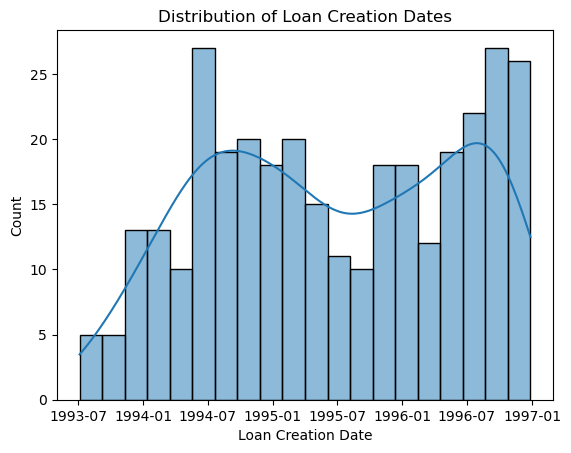

In [3066]:
loan_dev['date'] = pd.to_datetime(loan_dev['date'], format='%y%m%d')
sns.histplot(loan_dev['date'], bins=20, kde=True)
plt.xlabel('Loan Creation Date')
plt.title('Distribution of Loan Creation Dates')
plt.show()

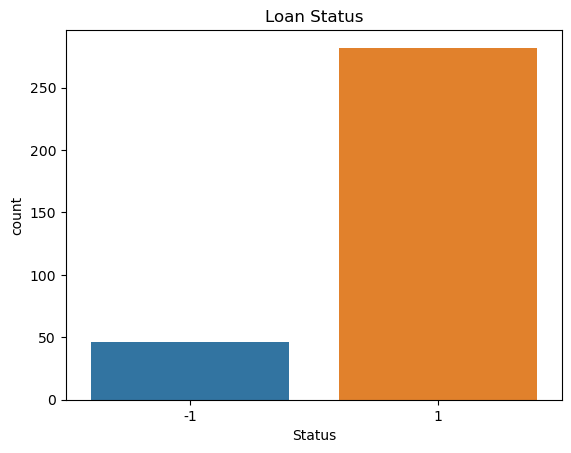

In [3067]:
sns.countplot(x='status', data=loan_dev)
plt.title("Loan Status")
plt.xlabel("Status")
plt.show()

In [3068]:
loan_dev.describe()

,loan_id,account_id,amount,duration,payments,status
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,6205.658537,5982.085366,145308.621951,35.853659,4150.932927,0.719512
std,667.985675,3213.262492,105247.318098,16.734752,2193.620989,0.695541
min,4959.000000,2.000000,4980.000000,12.000000,319.000000,-1.000000
25%,5604.250000,3079.000000,68328.000000,24.000000,2368.750000,1.000000
50%,6227.500000,6032.000000,114804.000000,36.000000,3878.500000,1.000000
75%,6737.250000,8564.500000,198600.000000,48.000000,5907.750000,1.000000
max,7308.000000,11362.000000,538500.000000,60.000000,9689.000000,1.000000


#### Missing Values

In [3069]:
print(loan_dev.isna().sum())
print()
print("There are " + str((loan_dev.isna().sum().sum())) + " NA values")

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

There are 0 NA values


#### Duplicate values

In [3070]:
print("Dataset length: " + str(len(loan_dev)))
print("Number of duplicates: " + str(loan_dev.duplicated().sum()))

Dataset length: 328
Number of duplicates: 0


#### Correlation matrix

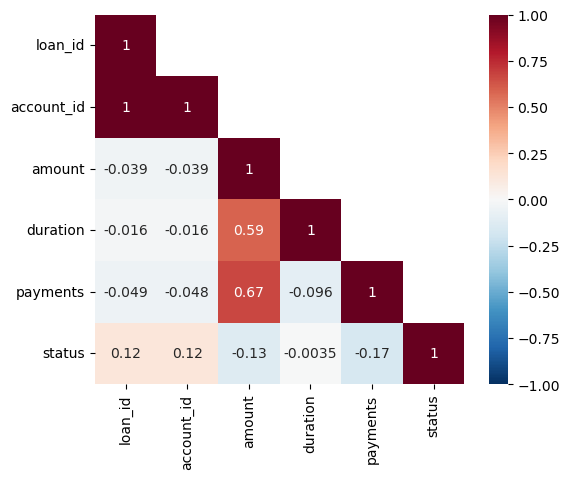

In [3071]:
numeric_cols = loan_dev.select_dtypes(include=np.number).columns.tolist()

corr_matrix = loan_dev[numeric_cols].corr()

mask = np.tri(corr_matrix.shape[0], dtype=bool)

sns.heatmap(corr_matrix, mask=~mask, cmap='RdBu_r', square=True, vmin=-1, vmax=1, annot=True)
plt.show()

#### Add loans to client

In [3072]:
# TODO Codigo comentado antigo, retirar?
'''columns_to_merge = ['account_id', 'amount', 'duration', 'status']

existing_columns = client.columns
columns_not_exist = [col for col in columns_to_merge if col not in existing_columns]

# Perform the merge only if there are columns that do not exist
if columns_not_exist:
    client = pd.merge(client, loan_dev[columns_to_merge], on='account_id', how='left')

client['amount'].fillna(0, inplace=True)
client['duration'].fillna(0, inplace=True)
client['status'].fillna(0, inplace=True)

client.head()'''
account_disp = pd.merge(account, disp, on='account_id', how='inner')
account_disp_client = pd.merge(client, account_disp, on='client_id', how='inner', suffixes=('_client', '_loan'))
account_disp_client_loan = pd.merge(loan_dev, account_disp_client, on='account_id', how='inner')
#account_disp_client_loan.head()


In [3076]:
account_disp_client_loan.head()

,account_id,district_id,frequency,date,disp_id,client_id,type
0,576,55,monthly issuance,1993-01-01,692,692,OWNER
1,576,55,monthly issuance,1993-01-01,693,693,DISPONENT
2,3818,74,monthly issuance,1993-01-01,4601,4601,OWNER
3,3818,74,monthly issuance,1993-01-01,4602,4602,DISPONENT
4,704,55,monthly issuance,1993-01-01,844,844,OWNER


In [112]:
'''loan_counts = account_disp_client_loan['client_id'].value_counts().reset_index()
loan_counts = account_client_loan['client_id'].value_counts().reset_index()
loan_counts.columns = ['client_id', 'number_loans']
client = client.merge(loan_counts, on='client_id', how='left')
client['number_loans'].fillna(0, inplace=True)
client.describe()'''

client.head()

,client_id,district_id,sex,age,account_id,amount,duration,status
0,1,18,Female,27,1,0.0,0.0,0.0
1,2,1,Male,52,2,80952.0,24.0,1.0
2,4,5,Male,41,3,0.0,0.0,0.0
3,6,12,Male,78,4,0.0,0.0,0.0
4,7,15,Male,68,5,0.0,0.0,0.0


### Decision tree test

In [1313]:
client.tail()

,client_id,district_id,sex,age,account_id,amount,duration,status,district_average_salary,unemployment_growth,commited_crimes_growth,entrepreneurs_percentage,urban_population_density
4495,13931,8,Male,55,11333,0.0,0.0,0.0,11277,0.19,-3.71,12.7,77773.110
4496,13955,1,Female,52,11349,419880.0,60.0,1.0,12541,0.14,15.68,16.7,1204953.000
4497,13968,61,Male,29,11359,54024.0,12.0,1.0,8814,0.98,-2.51,10.7,63428.586
4498,13971,67,Female,35,11362,129408.0,24.0,1.0,8110,0.78,-5.09,10.9,66920.074
4499,13998,74,Female,44,11382,0.0,0.0,0.0,10673,0.69,-2.32,10.0,323870.000


In [1325]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

clients_with_loans = client[client['status'].isin([1,-1])].copy()

X = clients_with_loans[['age' , 'amount', 'duration', 'district_average_salary' , 'unemployment_growth' , 'commited_crimes_growth' , 'entrepreneurs_percentage', 'urban_population_density',]]
y = clients_with_loans['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

clients_with_loans.describe()


,client_id,district_id,age,account_id,amount,duration,status,district_average_salary,unemployment_growth,commited_crimes_growth,entrepreneurs_percentage,urban_population_density
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,3.280000e+02
mean,7316.789634,38.112805,38.286585,5982.085366,145308.621951,35.853659,0.719512,9523.149390,0.639244,4.063841,12.144207,2.352892e+05
std,3975.749806,24.930903,12.548019,3213.262492,105247.318098,16.734752,0.695541,1319.525148,0.503628,11.659124,2.327964,3.753969e+05
min,2.000000,1.000000,17.000000,2.000000,4980.000000,12.000000,-1.000000,8110.000000,-0.360000,-72.000000,8.100000,2.072536e+04
25%,3723.750000,14.000000,27.000000,3079.000000,68328.000000,24.000000,1.000000,8546.250000,0.300000,-2.320000,10.700000,4.990540e+04
50%,7288.500000,40.000000,38.000000,6032.000000,114804.000000,36.000000,1.000000,8994.000000,0.580000,3.640000,11.500000,7.764707e+04
75%,10563.750000,61.250000,48.250000,8564.500000,198600.000000,48.000000,1.000000,9897.000000,0.850000,11.080000,13.500000,1.472330e+05
max,13971.000000,77.000000,62.000000,11362.000000,538500.000000,60.000000,1.000000,12541.000000,3.890658,27.890000,16.700000,1.204953e+06


In [1326]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6515151515151515
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.08      0.08      0.08        12
         1.0       0.79      0.78      0.79        54

    accuracy                           0.65        66
   macro avg       0.43      0.43      0.43        66
weighted avg       0.66      0.65      0.66        66

Confusion Matrix:
 [[ 1 11]
 [12 42]]


In [1322]:
feature_importances = model.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [0.17578875 0.34846859 0.06595251 0.01366134 0.0444353  0.15168717
 0.19075456 0.00925178]
